First, run this code cell:

In [1]:
import matplotlib.pyplot as plt
import spectrum_utils.spectrum as sus
import spectrum_utils.plot as sup

from scripts.ms2pip_utils import get_usi_spectrum, get_theoretical_spectrum, get_predicted_spectrum

# 1 Peptide spectrum prediction with MS²PIP

## 1.1 Observed and theoretical peptide fragmentation spectra

The intact mass of a peptide does not provide sufficient information to identify it in a complex sample. For instance, the peptides `ACDEK` and `EDCAK` share the same amino acid composition and have the exact same mass. As a result, these peptides are indistinguishable based on their intact mass alone (they are isomeric). More information on the peptide is therefore required.

Through peptide fragmentation, we can break a peptide into various fragment ions, each representing a part of the peptide sequence. Fragmentation takes place in the collision cell of the mass spectrometer and can be performed by colliding the peptides with an inert gas, such as argon. The resulting fragment ions are then acquired in the MS2 scan, making up the peptide fragmentation spectrum.

![LC-MS DDA overview](./images/1.1-lcms-dda-overview.png)

_Figure 1.1 Overview of a data-dependent mass spectrometry workflow with peptide fragmentation._

Using the Universal Spectrum Identifier<sup>[1]</sup>, we can directly download spectra from the PRIDE Archive. This spectrum was identified as peptide `VLHPLEGAVVIIFK` with precursor charge 2:

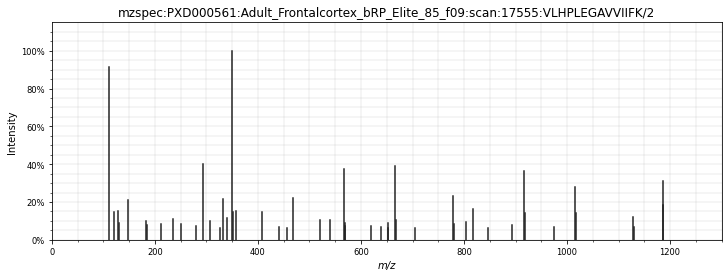

In [2]:
usi = "mzspec:PXD000561:Adult_Frontalcortex_bRP_Elite_85_f09:scan:17555:VLHPLEGAVVIIFK/2"
observed_spectrum = get_usi_spectrum(usi)

plt.figure(figsize=(12,4))
plt.title(usi)
sup.spectrum(observed_spectrum)
plt.show()

**How do we know that this is the spectrum for peptide `VLHPLEGAVVIIFK`?**

The most common fragment ion types from the _HCD_ and _CID_ fragmentation techniques are "b" and "y" ions. Each of these ions are the result of "breaking" the peptide in two parts. Depending on the location of the breakage along the peptide backbone, different b- or y-ion will be generated:

![image](https://www.bioinfor.com/wp-content/uploads/2016/11/denovo-screenshot.png)

_Figure 1.2 Example of peptide fragmentation._

As we know the masses of each amino acid, we can simply calculate the mass of each expected b- and y-ion for any given peptide:
- b-ions: Sum the masses of all amino acid residues and the mass of a proton
- y-ions: Sum the masses of all amino acid residues and add the mass of a proton and H<sub>2</sub>O.

We can fetch atomic masses from a list of the National Institute of Standards and Technology (NIST). For instance, `nist_mass["H"]` shows us the mass of hydrogen:

In [3]:
from pyteomics.mass import nist_mass

nist_mass["H"]

{0: (1.00782503207, 1.0),
 1: (1.00782503207, 0.999885),
 2: (2.0141017778, 0.000115),
 3: (3.0160492777, 0.0),
 4: (4.02781, 0.0),
 5: (5.03531, 0.0),
 6: (6.04494, 0.0),
 7: (7.05275, 0.0)}

_Question 1.1: Why are there multiple masses listed for hydrogen? What are the numbers between one and zero next to each mass value? Which mass value should we use in the context of mass spectrometry?_

The masses of the ion b<sub>2</sub> and the ion y<sub>7</sub> for the peptide in Figure 1.2 can be calculated as follows:

In [4]:
from pyteomics.mass import nist_mass, std_aa_mass, calculate_mass

hydrogen = nist_mass["H"][0][0]
oxygen = nist_mass["O"][0][0]

h2o = hydrogen * 2 + oxygen
proton = hydrogen

b2_mass = std_aa_mass["A"] + std_aa_mass["N"] + proton
y2_mass = sum([std_aa_mass[aa] for aa in "ELLLNVK"]) + proton + h2o

print("b2 =", b2_mass, "Da")
print("y7 =", y2_mass, "Da")

b2 = 186.08786503207 Da
y7 = 828.5194597157698 Da


These numbers should match the annotations in Figure 1.2.

The Python package [`pyteomics`](https://pyteomics.readthedocs.io/)<sup>[2]</sup> contains a function that can calculate the mass of any peptide ion:

In [5]:
calculate_mass(sequence="ELLLNVK", ion_type="y", charge=1)

828.51893053796

Using these formulae, we can calculate a full _theoretical fragmentation spectrum_. Such a spectrum shows us where to expect peaks and where not. This information helps us to identify an MS2 spectrum. The theoretical spectrum for our downloaded spectrum from PRIDE Archive would contain the following b-ions:

In [6]:
peptide = "VLHPLEGAVVIIFK"

for i, amino_acid in enumerate(peptide[:-1]):
    ion_mass = calculate_mass(sequence=peptide[:i+1], ion_type="b", charge=1)    
    print(f"b{i+1}\t{ion_mass:.2f} Da\t", peptide[:i+1])

b1	100.08 Da	 V
b2	213.16 Da	 VL
b3	350.22 Da	 VLH
b4	447.27 Da	 VLHP
b5	560.36 Da	 VLHPL
b6	689.40 Da	 VLHPLE
b7	746.42 Da	 VLHPLEG
b8	817.46 Da	 VLHPLEGA
b9	916.53 Da	 VLHPLEGAV
b10	1015.59 Da	 VLHPLEGAVV
b11	1128.68 Da	 VLHPLEGAVVI
b12	1241.76 Da	 VLHPLEGAVVII
b13	1388.83 Da	 VLHPLEGAVVIIF


The full theoretical spectrum looks like this:

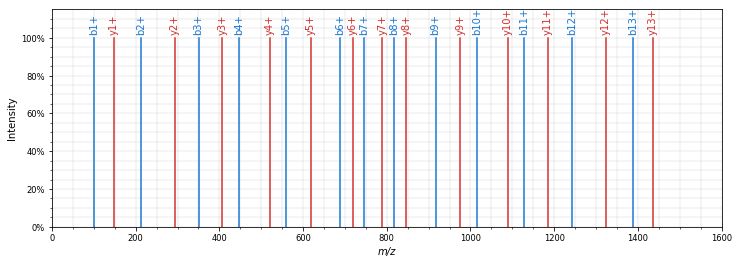

In [7]:
theoretical_spectrum = get_theoretical_spectrum("VLHPLEGAVVIIFK", modifications="-", charge=2)

plt.figure(figsize=(12,4))
sup.spectrum(theoretical_spectrum)
plt.show()

_Question 1.2: Run the code cell below. Often, a theoretical spectrum is instead visualized like the one below, why would that be?_

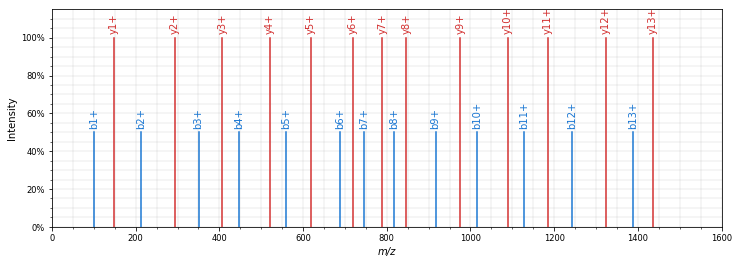

In [8]:
theoretical_spectrum = get_theoretical_spectrum("VLHPLEGAVVIIFK", modifications="-", charge=2, b_ion_weight=0.5)

plt.figure(figsize=(12,4))
sup.spectrum(theoretical_spectrum)
plt.show()

By matching an observed spectrum - such as the one downloaded before - with a theoretical spectrum, we can assess the probability that the peptide-to-spectrum match (PSM) is correct:

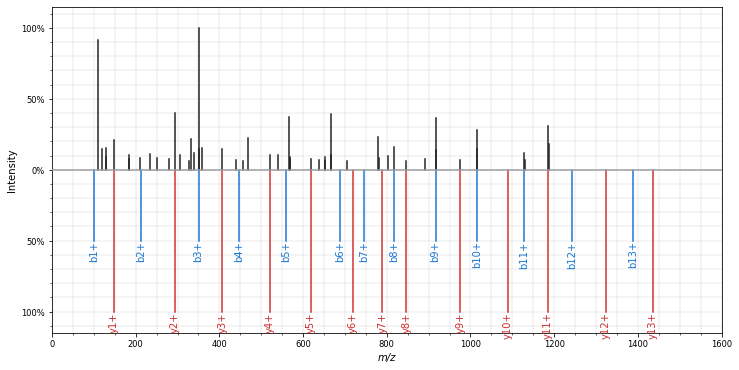

In [9]:
plt.figure(figsize=(12,6))
sup.mirror(observed_spectrum, theoretical_spectrum)
plt.show()

We can also annotate the observed spectrum accordingly:

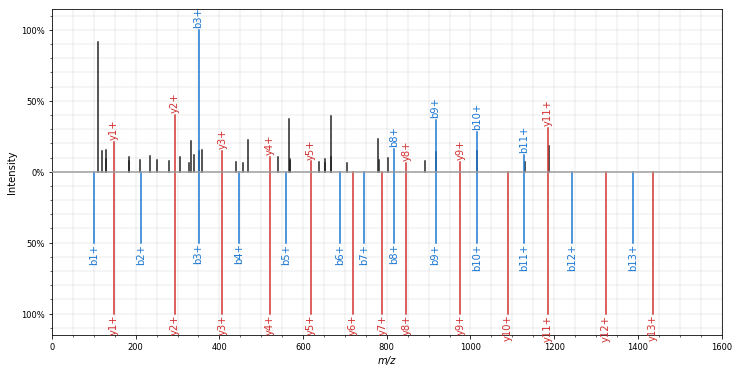

In [10]:
observed_spectrum.annotate_peptide_fragments(0.02, "Da")

plt.figure(figsize=(12,6))
sup.mirror(observed_spectrum, theoretical_spectrum)
plt.show()

_Question 1.3: In the above code, what would the `0.02 Da` mean? Why is this important?_

How well do the spectra match? Are all peaks matched? Are all peaks as intense as you would expect?

_Question 1.4: None of the theoretical ions with an m/z higher than 1200 Da can be matched. Why would that be?_


## 1.2 Predicted peptide fragmentation spectra

As you probably noticed, while we can simply calculate the fragment ion _m/z_ values for any given peptide, the resulting theoretical spectrum does not really resemble an observed spectrum. Many peaks are not as intence, many others are not present at all. Unfortunately, we cannot simply calculate the expected intensity of fragment ion peaks. This is where more complex models are required; models that can be learned from thousands of observed fragmentation spectra with machine learning (ML).

MS²PIP<sup>[3]</sup> employs the XGBoost library, which is an advanced ML algorithm based on decision trees. 

[TODO]

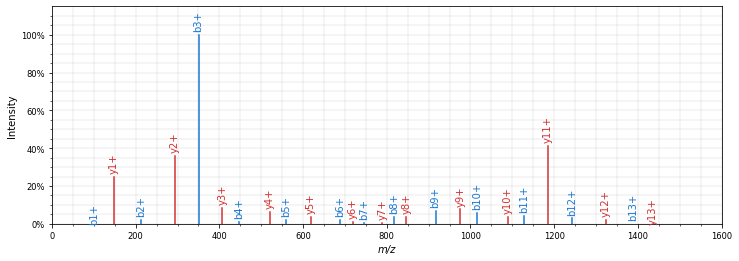

In [11]:
predicted_spectrum = get_predicted_spectrum("VLHPLEGAVVIIFK", modifications="-", charge=2)

plt.figure(figsize=(12,4))
sup.spectrum(predicted_spectrum)
plt.show()

Let's compare it to the observed spectrum:

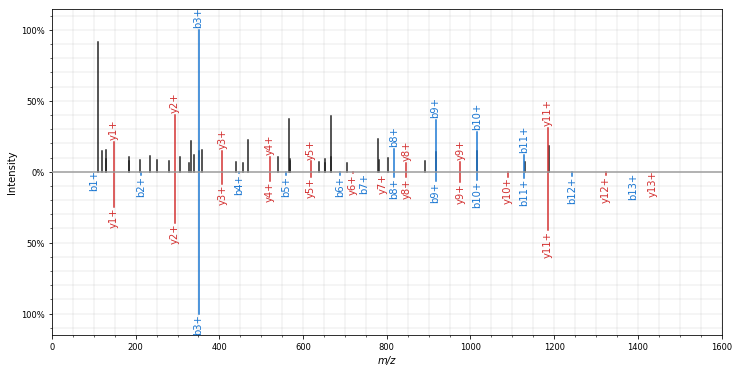

In [12]:
plt.figure(figsize=(12,6))
sup.mirror(observed_spectrum, predicted_spectrum)
plt.show()

MS²PIP correctly predicted the b<sub>3</sub> ion to be the most intense, followed by the y<sub>11</sub>, y<sub>2</sub> and then y<sub>1</sub>. In this case, it did miss the more intense b<sub>8-11</sub> ions. Nevertheless, it is a much closer resemblance to the observed spectrum. The brilliant aspect of spectrum prediction, is that you can run it for ANY peptide, even peptides that have not been observed before. If you don't have any non-amino acid characters (B, J, O, U, X, or Z)  in your name, fill it in below, and let's see what your peptide looks like!

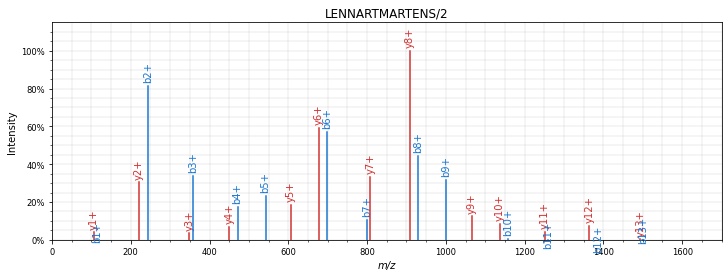

In [13]:
your_name = "LENNARTMARTENS"  # <-- Fill in your name here
charge = 2                    # <-- Try different precursor charge states (positive values, e.g. between 2 and 6)

predicted_spectrum = get_predicted_spectrum(your_name, modifications="-", charge=charge)

plt.figure(figsize=(12,4))
plt.title(your_name + "/" + str(charge))
sup.spectrum(predicted_spectrum)
plt.show()

You can also try spectra for different charge states. Change the `charge` variable in the previous code cell, and rerun.

Note that depending on the amino acid composition of the peptide, some higher charge states will be very unlikely to occur. Still, MS²PIP will attempt to predict what the spectrum would like like in such a case, however unlikely it is to exist.

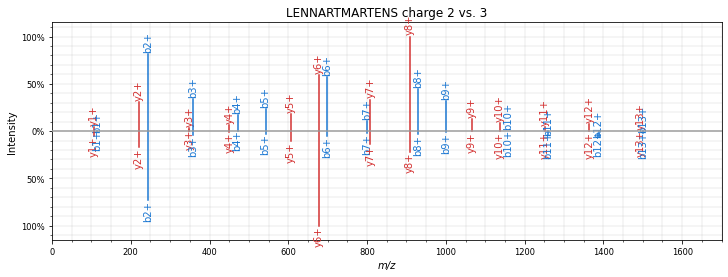

In [14]:
top_spectrum = get_predicted_spectrum("LENNARTMARTENS", modifications="-", charge=2)
bottom_spectrum = get_predicted_spectrum("LENNARTMARTENS", modifications="-", charge=3)

plt.figure(figsize=(12,4))
plt.title(your_name + " charge 2 vs. 3")
sup.mirror(top_spectrum, bottom_spectrum)
plt.show()

_Question 1.5 Interestingly, while the precursor charge state does not influence the location of the fragment ion peaks, it has a large influence on the fragment intensities. Why would that be?_

## 1.3 Considering peptide modification mass shifts

One of the options for MS²PIP is `modifications`. As all post-translational and artefactual peptide modifications introduce a mass shift to all fragment ions that carry the modification, MS²PIP needs to know the presense of any modifications on the peptide. This includes both "variable" and "fixed" modifications, regardless of how they were set in the search engine. 

To consider peptide modifications, MS²PIP first needs a record of modification names, the amino acids they occur on, and the corresponding mass shift that is introduced:

In [15]:
from ms2pip.single_prediction import SinglePrediction

ms2pip = SinglePrediction(
    modification_strings=[
        "Oxidation,15.994915,opt,M",
        "Carbamidomethyl,57.021464,opt,C",
        "PhosphoS,79.966331,opt,S",
        "PhosphoT,79.966331,opt,T",
        "PhosphoY,79.966331,opt,Y",
        "iTRAQK,144.102063,opt,K",
        "iTRAQN,144.102063,opt,N-term",
    ]
)

For modifications that occur on multiple amino acids - such as phosphorylation and iTRAQ - MS²PIP requires an individual entry for each site and each name should be unique.

_Question 1.6: Note that the last modification entry `N-term` is listed instead of an amino acid. Why is that? What is the difference between a modification on the first amino acid versus a modification on the N-terminus?_

Next, MS²PIP needs to know for each peptide the location of all modifications. For this, we start counting amino acid residues from 1. The numbers `0` and `-1` are reserved for the N-terminus and the C-terminus, respectively. For example:

- `A C[Carbamidomethyl] D M K` = 2 Carbamidomethyl
- `A C[Carbamidomethyl] D M[Oxidation] K` = 2 Carbamidomethyl, 4 Oxidation
- `[Acetyl] A C[Carbamidomethyl] D M[Oxidation] K` = 0 Acetyl 2 Carbamidomethyl, 4 Oxidation

All modification names and locations are then merged with a "pipe" sign (`|`):

- `A C[Carbamidomethyl] D M K` = `2|Carbamidomethyl`
- `A C[Carbamidomethyl] D M[Oxidation] K` = `2|Carbamidomethyl|4|Oxidation`
- `[Acetyl] A C[Carbamidomethyl] D M[Oxidation] K` = `0|Acetyl|2|Carbamidomethyl|4|Oxidation`

A peptide without modifications should have the listing `-`.


Then we can run, for instance:

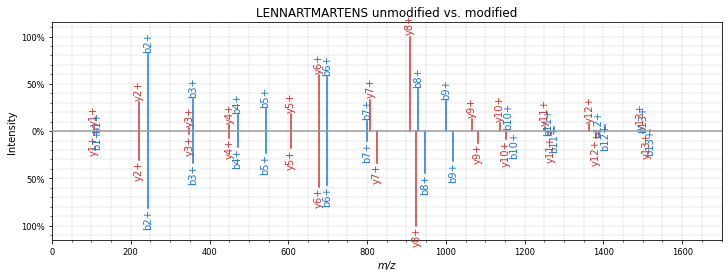

In [17]:
top_spectrum = get_predicted_spectrum("LENNARTMARTENS", modifications="-", charge=2, ms2pip_instance=ms2pip)
bottom_spectrum = get_predicted_spectrum("LENNARTMARTENS", modifications="8|Oxidation", charge=2, ms2pip_instance=ms2pip)

plt.figure(figsize=(12,4))
plt.title("LENNARTMARTENS" + " unmodified vs. modified")
sup.mirror(top_spectrum, bottom_spectrum)
plt.show()

_Question 1.7: Which ions carry the modification? How much are they shifted?_


## 1.4 Considering factors that influence the fragmentation pattern

Before, you saw how the precursor charge changes the resulting fragmentation pattern, and how MS²PIP takes this into account. There are more factors that influence peptide fragmentation patterns, and MS²PIP provides specialized models for the most prevalent ones:

- Other fragmentation methods: trap-type CID (ion trap)
- Other instruments: Quadrupole Time-of-Flight
- Quantification labels: TMT or iTRAQ
- Special peptide properties: Alternative digest or immunopeptides

Let's start with quantification labels as an example. TMT and iTRAQ provide an ingenious method to label peptides from different samples (e.g. treatment and control), pool the samples together, identify all samples in a single run, and finally quantify peptides from each sample separately through peptide fragmentation. This can be achieved with the use of cleavable reporter ions. Each sample is labeled with a specific tag molecule with a distinct reporter ion mass. Thanks to a balance group on the whole label, the mass of the intact label is identical across samples. The result is that the peptides from each sample will group together in both MS1 and MS2 spectra, but after fragmentation, the reporter ions can be observed at distinct masses in the MS2 spectrum.


![tmt figure](https://miro.medium.com/max/1111/1*Y4yQI2eKoeR6aVDF6wJCkA.jpeg)

### References:
[1] Deutsch, E. W., Perez-Riverol, Y., Carver, J., Kawano, S. Mendoza, L., van den Bossche, T., Gabriels, R., Binz, P.-A., Pullman, B., Sun, Z., Shofstahl, J., Bittremieux, W., Mak, T. D., Klein, J., Zhu, Y., Lam, H., Vizcaíno, J. A., &#38; Bandeira, N. (2021). Universal Spectrum Identifier for mass spectra. <i>Nature Methods</i>, 1–3. https://doi.org/10.1038/s41592-021-01184-6

[2] Levitsky, L. I., Klein, J. A., Ivanov, M. v., &#38; Gorshkov, M. v. (2019). Pyteomics 4.0: Five Years of Development of a Python Proteomics Framework. <i>Journal of Proteome Research</i>, <i>18</i>(2), 709–714. https://doi.org/10.1021/ACS.JPROTEOME.8B00717/

[3] Gabriels, R., Martens, L., &#38; Degroeve, S. (2019). Updated MS<sup>2</sup>PIP web server delivers fast and accurate MS<sup>2</sup> peak intensity prediction for multiple fragmentation methods, instruments and labeling techniques. <i>Nucleic Acids Research</i>, <i>47</i>(W1), W295--W299. https://doi.org/10.1093/nar/gkz299